In [1]:
# Imports
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
# Load data
train = np.loadtxt('dataset/exoTrain.csv', delimiter=",", skiprows=1, dtype=np.float32)
test = np.loadtxt('dataset/exoTest.csv', delimiter=",", skiprows=1, dtype=np.float32)

In [3]:
# Normalize all data
train[:,1:] = (train[:,1:] - np.mean(train[:,1:], axis=1).reshape(-1,1) / np.std(train[:,1:], axis=1).reshape(-1,1))
train[:,:1] = train[:,:1] - 1
test[:,1:] = (test[:,1:] - np.mean(test[:,1:], axis=1).reshape(-1,1) / np.std(test[:,1:], axis=1).reshape(-1,1))
test[:,:1] = test[:,:1] - 1

# Augment train data
idx_one = np.where(train[:,:1] == 1)[0]
idx_zero = np.where(train[:,:1] == 0)[0]
new_rows = np.zeros([len(idx_zero) - len(idx_one), train.shape[1]], dtype='float32')
for i in range(len(idx_zero) - len(idx_one)):
    idx_source = np.random.randint(len(idx_one))
    time_shift = np.random.randint(train.shape[1] - 1)
    new_rows[i,:1] = train[idx_source][:1]
    new_rows[i,1:] = np.roll(train[idx_source][1:], time_shift)
train = np.vstack([train, new_rows])

# Add dimension
x_train = np.expand_dims(train[:, 1:], axis=2)
x_test = np.expand_dims(test[:, 1:], axis=2)
y_train = np.expand_dims(train[:, 0].astype(np.int32), axis=1)
y_test = np.expand_dims(test[:, 0].astype(np.int32), axis=1)

In [84]:
# Create Dataset and Iterator
batch_size = 32
tf.reset_default_graph()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
train_iter_op = iterator.make_initializer(train_dataset)
test_iter_op = iterator.make_initializer(test_dataset)
next_batch = iterator.get_next()

In [85]:
# Build graph
x_batch, y_batch = next_batch

conv1_1_w = tf.get_variable('conv1_1_w', shape=[100, 1, 5])
conv1_2_w = tf.get_variable('conv1_2_w', shape=[20, 1, 5])
conv2_w = tf.get_variable('conv2_w', shape=[11, 10, 64])

conv1_1_b = tf.get_variable('conv1_1_b', 5, initializer=tf.zeros_initializer())
conv1_2_b = tf.get_variable('conv1_2_b', 5, initializer=tf.zeros_initializer())
conv2_b = tf.get_variable('conv2_b', 64, initializer=tf.zeros_initializer())

#keep_prob = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

conv1_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(x_batch, conv1_1_w, 1, 'SAME'), conv1_1_b))
conv1_1 = tf.layers.max_pooling1d(conv1_1, pool_size=4, strides=4, padding='VALID')

conv1_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(x_batch, conv1_2_w, 1, 'SAME'), conv1_2_b))
conv1_2 = tf.layers.max_pooling1d(conv1_2, pool_size=4, strides=4, padding='VALID')

model_out = tf.concat([conv1_1, conv1_2], -1)

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(model_out, conv2_w, 1, 'VALID'), conv2_b))
model_out = tf.layers.max_pooling1d(model_out, pool_size=4, strides=4, padding='VALID')

model_out = tf.nn.dropout(model_out, 0.90)

model_out = tf.contrib.layers.flatten(model_out)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, 0.80)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.contrib.layers.fully_connected(model_out, 1, activation_fn=None)

loss = tf.losses.sigmoid_cross_entropy(y_batch, model_out)

training_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.sigmoid(model_out)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_int32(tf.greater(prediction, threshold)), y_batch)))

In [86]:
Epoch_Data = namedtuple('Epoch_data', ['loss', 'acc', 'pred', 'time'])

def run_epoch(iter_init_op, train=False, lr=0.00001, thresh=0.8):
    
    fetch_list = [loss, prediction, accuracy, training_op] if train else [loss, prediction, accuracy]        
    start_time = time.time()
    losses = []
    predictions = []
    accs = []
    sess.run(iter_init_op)
    while True:
        try:
            batch_outputs = sess.run(fetch_list, feed_dict={learning_rate: lr, threshold: thresh})
            losses.append(batch_outputs[0])
            predictions.append(batch_outputs[1])
            accs.append(batch_outputs[2])                
        except tf.errors.OutOfRangeError:
            break
    epoch_time = time.time() - start_time
    
    return Epoch_Data(np.mean(losses), np.mean(accs), np.concatenate(predictions), epoch_time)

In [92]:
# Train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())
epoch_datas = []

for epoch in range(400):
    train_data = run_epoch(train_iter_op, train=True, lr=0.1)
    test_data = run_epoch(test_iter_op, train=False)
    epoch_datas.append({'count': epoch + 1, 'train_data': train_data, 'test_data': test_data})
    printables = (epoch + 1, train_data.time + test_data.time, train_data.acc, train_data.loss, test_data.acc)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 

Epoch 01	Duration: 03s	Train accuracy: 0.9829	Train loss: 0.8454	Test accuracy: 0.9784
Epoch 02	Duration: 02s	Train accuracy: 0.9836	Train loss: 0.4640	Test accuracy: 0.9836
Epoch 03	Duration: 02s	Train accuracy: 0.9854	Train loss: 0.2050	Test accuracy: 0.9870
Epoch 04	Duration: 02s	Train accuracy: 0.9864	Train loss: 0.1355	Test accuracy: 0.9857
Epoch 05	Duration: 02s	Train accuracy: 0.9846	Train loss: 0.2111	Test accuracy: 0.9766
Epoch 06	Duration: 02s	Train accuracy: 0.9833	Train loss: 0.4146	Test accuracy: 0.9822
Epoch 07	Duration: 02s	Train accuracy: 0.9870	Train loss: 0.2447	Test accuracy: 0.9857
Epoch 08	Duration: 02s	Train accuracy: 0.9864	Train loss: 0.0813	Test accuracy: 0.9853
Epoch 09	Duration: 02s	Train accuracy: 0.9860	Train loss: 0.2908	Test accuracy: 0.9836
Epoch 10	Duration: 02s	Train accuracy: 0.9866	Train loss: 0.1104	Test accuracy: 0.9840
Epoch 11	Duration: 02s	Train accuracy: 0.9881	Train loss: 0.7364	Test accuracy: 0.9840
Epoch 12	Duration: 02s	Train accuracy: 0.98

Epoch 96	Duration: 02s	Train accuracy: 0.9944	Train loss: 0.1575	Test accuracy: 0.9909
Epoch 97	Duration: 02s	Train accuracy: 0.9953	Train loss: 0.1355	Test accuracy: 0.9927
Epoch 98	Duration: 03s	Train accuracy: 0.9953	Train loss: 0.6895	Test accuracy: 0.9931
Epoch 99	Duration: 02s	Train accuracy: 0.9951	Train loss: 1.1818	Test accuracy: 0.9927
Epoch 100	Duration: 02s	Train accuracy: 0.9958	Train loss: 0.8165	Test accuracy: 0.9857


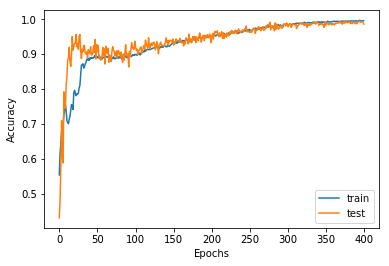

In [93]:
plt.plot([epoch_datas[x]['train_data'].acc for x in range(len(epoch_datas))])
plt.plot([epoch_datas[x]['test_data'].acc for x in range(len(epoch_datas))])
plt.legend(['train', 'test'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()